<a href="https://colab.research.google.com/github/simeon-velev/fake_news_with_LSTM/blob/main/FakeNews_Detection_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf

from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer

In [2]:
# Connect to Google Drive 
# Upload the dataset to your Google drive so it can be loaded here

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
fake_news = pd.read_csv('/content/gdrive/My Drive/Fake.csv')
fake_news = fake_news.fillna(' ')
real_news = pd.read_csv('/content/gdrive/My Drive/True.csv')
real_news = real_news.fillna(' ')

In [4]:
print(f"The shape of the Real News is {real_news.shape}")
print(f"The shape of the Fake News is {fake_news.shape}")

The shape of the Real News is (21417, 4)
The shape of the Fake News is (23481, 4)


In [5]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
fake_news.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [7]:
fake_news['label'] = 0
fake_news.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [8]:
real_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [9]:
real_news.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [10]:
real_news['label'] = 1
real_news.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [11]:
data = pd.concat([real_news, fake_news]).reset_index(drop = True)

In [12]:
data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [13]:
fake_news["subject"].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

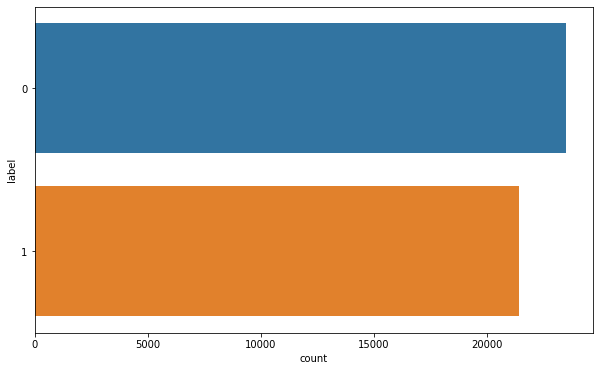

The total Fake News (0) are 23481
The total Real News (1) are 21417


In [14]:
plt.figure(figsize = (10, 6))
sns.countplot(y = "label", data = data)
plt.show()

print(f"The total Fake News (0) are {(data.label == 0).sum()}")
print(f"The total Real News (1) are {(data.label == 1).sum()}")

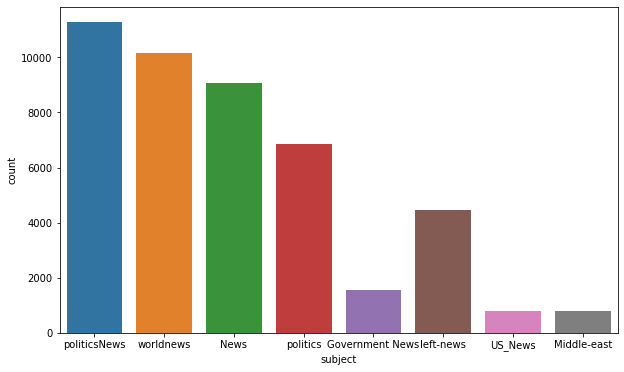

In [15]:
plt.figure(figsize = (10, 6))
sns.countplot(x = "subject", data = data)
plt.show()

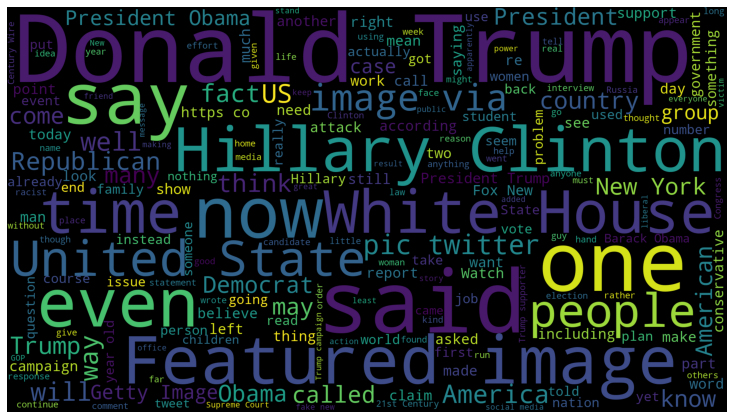

In [16]:
#creating wordcloud for fake news
fake_text = ' '.join(fake_news["text"].tolist())

fake_wordcloud = WordCloud(width=1920, height= 1080).generate(fake_text)
fig = plt.figure(figsize= (10, 10))
plt.imshow(fake_wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

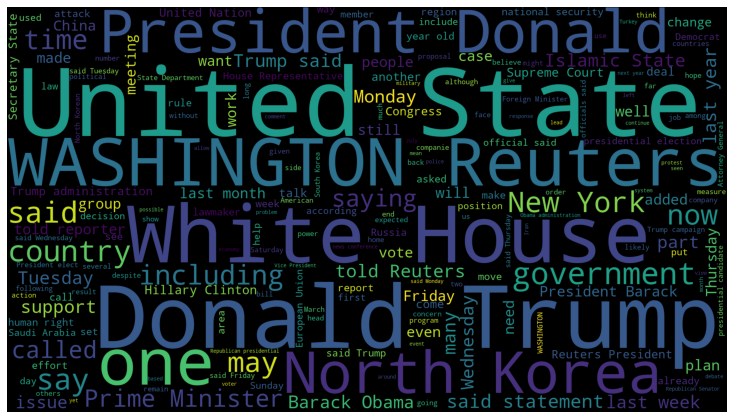

In [17]:
#creating wordcloud for real news
real_text = ' '.join(real_news["text"].tolist())

real_wordcloud = WordCloud(width=1920, height= 1080).generate(real_text)
fig = plt.figure(figsize= (10, 10))
plt.imshow(real_wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

As we can see in the two wordclouds, the one for fake news doesn contain officila news publisher such as REUTERS, which can be seen in real news wordcloud. In fake news wordcloud we can see twitter, which is a social media site, not a news site

In [18]:
#remove the unnecessary data
data.drop(columns = ['date'], inplace = True)

In [19]:
data.head()

,title,text,subject,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1


In [20]:
data['original'] = data['title'] + ' ' + data['text']
data.head()

,title,text,subject,label,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...


In [21]:
data['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [22]:
X = data.drop('label', axis = 1)
y = data['label']

In [23]:
X.shape, y.shape

((44898, 4), (44898,))

In [24]:
#choosing vocabulary size to be 5000 and copying data to text for further cleaning
#voc_size = 5000
text = X.copy()

In [25]:
#dowonloading stopword and continue with data cleaning
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
#we will use stemming to map the words to their root forms 
ps = PorterStemmer()
corpus = []

In [27]:
#applying stemming and some preprocessing
for i in range(len(text)):
  review = re.sub('[^a-zA-Z]',' ',text['original'][i])
  review = review.lower()
  review = review.split()
  review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
  review = ' '.join(review)
  corpus.append(review)

In [28]:
corpus[0]

'u budget fight loom republican flip fiscal script washington reuter head conserv republican faction u congress vote month huge expans nation debt pay tax cut call fiscal conserv sunday urg budget restraint keep sharp pivot way among republican u repres mark meadow speak cb face nation drew hard line feder spend lawmak brace battl januari return holiday wednesday lawmak begin tri pass feder budget fight like link issu immigr polici even novemb congression elect campaign approach republican seek keep control congress presid donald trump republican want big budget increas militari spend democrat also want proport increas non defens discretionari spend program support educ scientif research infrastructur public health environment protect trump administr alreadi will say go increas non defens discretionari spend percent meadow chairman small influenti hous freedom caucu said program democrat say enough need give govern pay rais percent fiscal conserv see rational eventu run peopl money sai

In [29]:
tf.keras.backend.clear_session()

In [30]:
#converting to one hot representation
#onehot_rep = [one_hot(words,voc_size)for words in corpus]

In [31]:
# Tokenize text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
vocab_size=len(word_index)
print(vocab_size)

# Padding data

sequences = tokenizer.texts_to_sequences(corpus)
padded = pad_sequences(sequences, maxlen=50, padding='post', truncating='post')

89887


In [32]:
#padding Sentences to make them of same size
#embedded_docs = pad_sequences(onehot_rep,padding='post', maxlen = 500)

In [33]:
X_train,X_test,y_train,y_test = train_test_split(np.array(padded),np.array(y), test_size=0.2, random_state = 42)

X_train.shape,y_train.shape,X_test.shape, y_test.shape

((35918, 50), (35918,), (8980, 50), (8980,))

In [34]:
# Build the architecture of the model
     
model = Sequential([
    Embedding(vocab_size, 50, input_length = 50),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dropout(0.3),
    Dense(64, activation = "relu"),
    Dropout(0.2),
    Dense(32, activation = "relu"),
    Dropout(0.2),
    Dense(1, activation = "sigmoid"),
])

In [35]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=3, batch_size=128, validation_data=[X_test, y_test])

print("Training Complete")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            4494350   
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm (LSTM)                 (None, 50, 128)           91648     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

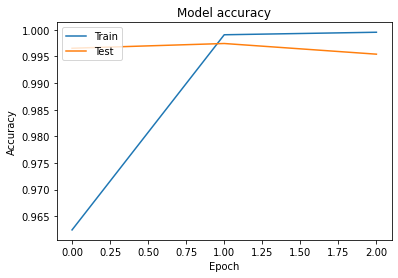

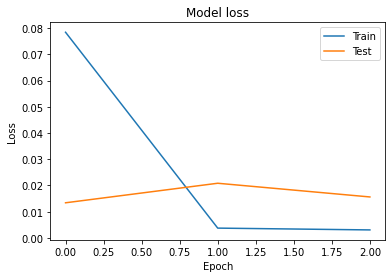

In [36]:
# Visualize the results:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()